In [63]:
import os
import time
import pytz
from scipy import stats
import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, NullFormatter

import pytz


In [5]:
root_dataset = "path to machine metric dataset"

In [3]:
# Count the number of physical cores in LISA so that we can compare it with the summed load1 metric across all nodes.
# Based on https://userinfo.surfsara.nl/systems/lisa/description accessed on 2020-10-08
number_of_cores_in_lisa = 0
number_of_cores_in_lisa += 23  * 6  # Intel® Xeon® Bronze 3104 Processor 
number_of_cores_in_lisa += 2   * 6  # Intel® Xeon® Bronze 3104 Processor 
number_of_cores_in_lisa += 29  * 12 # Intel® Xeon® Gold 5118 Processor 
number_of_cores_in_lisa += 192 * 16 # Intel® Xeon® Gold 6130 Processor 
number_of_cores_in_lisa += 96  * 8  # Intel® Xeon® Silver 4110 Processor 
number_of_cores_in_lisa += 1   * 12 # Intel® Xeon® Gold 6126 Processor 
print(number_of_cores_in_lisa)

4350


In [6]:
# Perform the load1 computation
load1_df = pd.read_parquet(os.path.join(root_dataset, "node_load1"))
# load1_df["dt"] = pd.to_datetime(df_1128.index, utc=True, unit="s")
# load1_df["dt"] = load1_df["dt"].dt.tz_convert(pytz.timezone('Europe/Amsterdam')).dt.tz_localize(None)
# load1_df = load1_df.set_index("dt")
load1_df.replace(-1.0, 0, inplace=True) # Make sure we set "invalid values" to 0 to avoid influencing the sum
load1_df = load1_df.sum(axis=1, skipna=True) # Sum the values across the columns (axis = 1), so we get per timestamp the total load1 across LISA

load1_df = load1_df / number_of_cores_in_lisa
load1_df.clip(upper=1.0, inplace=True)  # Clip values above the number of cores to 1 ()
load1_df.max()

1.0

In [5]:
load1_df.index.min()

1577685615

In [7]:
max_tempature_allowed =  77  # based on https://ark.intel.com/content/www/us/en/ark/products/123547/intel-xeon-silver-4110-processor-11m-cache-2-10-ghz.html which has the lowest T_CASE across all

# Perform the ambient temperature computation
rack_temp = pd.read_parquet(os.path.join(root_dataset, "surfsara_ambient_temp"))
rack_temp.replace(-1.0, np.nan, inplace=True)  # Set -1 values which are invalid to NaNs so we can omit them.
rack_temp = rack_temp.mean(axis=1, skipna=True)  # Compute the mean, skip NaNs
rack_temp.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.
rack_temp = rack_temp / max_tempature_allowed
rack_temp.clip(upper=1.0, inplace=True)  # Clip values above 1 with respect to max_tempature_allowed
rack_temp.max()

0.33402266523285634

In [8]:
# LISA has two types of GPUs:
# GeForce 1080Ti and Titan V. Both have the Thermal Threshold of 91 degree Celcius.
# https://www.nvidia.com/en-sg/geforce/products/10series/geforce-gtx-1080-ti/
# https://www.nvidia.com/en-us/titan/titan-v/
max_gpu_tempature_allowed =  91

# Perform the ambient temperature computation
gpu_temp = pd.read_parquet(os.path.join(root_dataset, "nvidia_gpu_temperature_celsius"))
gpu_temp.replace(-1.0, np.nan, inplace=True)  # Set -1 values which are invalid to NaNs so we can omit them.
gpu_temp = gpu_temp.mean(axis=1, skipna=True)  # Compute the mean, skip NaNs
gpu_temp.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.
gpu_temp = gpu_temp / max_gpu_tempature_allowed
gpu_temp.clip(upper=1.0, inplace=True)  # Clip values above 1 with respect to max_tempature_allowed

In [9]:
# The average power consumption throught the datacenter.
# The cooling for all the racks is the same, with a capability of max 5500 Watts

cluster_power_df = pd.read_parquet(os.path.join(root_dataset, "surfsara_power_usage"))

cluster_power_df.replace(-1.0, np.nan, inplace=True)  # Set -1 values which are invalid to NaNs so we can omit them.

# Drop columns that only have NaN values, we need to drop them because they will add to max_allowed_power_consumption but do not contribute in the sum.
cluster_power_df.dropna(how='all', axis=1, inplace=True) 
cluster_power_df.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.

# Lisa's cooling system can handle 5500 Watt per rack, compute this ceiling.
max_allowed_power_consumption = 5500 * len({col.split("n")[0] for col in cluster_power_df.columns})

cluster_power_df = cluster_power_df.sum(axis=1, skipna=True)  # Compute the mean, skip NaNs
cluster_power_df = cluster_power_df / max_allowed_power_consumption
cluster_power_df.clip(upper=1.0, inplace=True)  # Clip values above 1 as we know values can exceed the cooling system's capability.
cluster_power_df.max()

0.8290666666666666

In [10]:
# RAM usage computation.
memory_total = pd.read_parquet(os.path.join(root_dataset, "node_memory_MemTotal"))
memory_free = pd.read_parquet(os.path.join(root_dataset, "node_memory_MemFree"))

# Align the two dataframes, use inner so that all mismatched between columns and timestmaps are dropped.
# Axis = none aligns on both index AND columns, which is what we want.
memory_total, memory_free = memory_total.align(memory_free, join="inner", axis=None)

# We can now devide safely because all indices and columns are aligned.
memory_df = memory_free / memory_total
del memory_total, memory_free # Free up RAM during computation

# Switch to memory_consumed rather than free
memory_df = 1 - memory_df

# Compute the average
memory_df = memory_df.mean(axis=1, skipna=True)
print(memory_df)

1577685615    0.137794
1577685630    0.145134
1577685645    0.145976
1577685660    0.145503
1577685675    0.145419
                ...   
1589925525    0.138196
1589925540    0.138075
1589925555    0.137709
1589925570    0.137474
1589925585    0.137419
Length: 804719, dtype: float64


In [11]:
# GPU fan speed computation
max_fanspeed =  100  # It's percentage based 

gpu_fanspeed_df = pd.read_parquet(os.path.join(root_dataset, "nvidia_gpu_fanspeed_percent"))
gpu_fanspeed_df.replace(-1.0, np.nan, inplace=True)  # Set -1 values which are invalid to NaNs so we can omit them.
gpu_fanspeed_df = gpu_fanspeed_df.mean(axis=1, skipna=True)  # Compute the mean, skip NaNs
gpu_fanspeed_df.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.
gpu_fanspeed_df = gpu_fanspeed_df / max_fanspeed
gpu_fanspeed_df.max()

0.5461344537815126

In [12]:
# GPU memory computation
gpu_memory_df = pd.read_parquet(os.path.join(root_dataset, "nvidia_gpu_memory_used_bytes"))

# # Here, we need to do a bit of computation.
# # There are three GPU versions in the cluster, the GTX 1080 ti with 11GB or RAM and the Titan V / Titan RTX, which have 12 and 24GB of RAM.
# # We first ceil the maximum usage per node and ceil it. Then per rack, we find the maximum value and set that maximum to all nodes.
# # If the maximum is >11.0 then it must be a Titan with 24GB. If the value is <= 11.0 then we assume it's the 1080 ti.
# # This means that a poorly used Titans across its entire lifespan (which is possibly, but unlikely) will be classified as a 1080ti, but 
# # as this is highly unlikely, we beleive this is for now the best approach given the data.
# ceiled_values = np.ceil((gpu_memory_df.max() / (1024*1024*1024)))

# # Based on https://github.com/sara-nl/SURFace/blob/master/node%20information.md

# node_max = dict()
# for index, value in ceiled_values.items():
#     if value > 12.0 or index in confirmed_titan_nodes:
#         value = 24.0
#     elif value > 11.0:
#         value = 12.0
#     else:
#         value = 11.0
    
#     if index not in node_max:
#         node_max[index] = value
    
#     node_max[index] = max(node_max[index], value)

# print(node_max)

# # gpu_memory_df.replace(-1.0, np.nan, inplace=True)  # Set -1 values which are invalid to NaNs so we can omit them.

# # Devide all values based on the found maximum.
# for node_name, max_gpu_value in node_max.items():
#     gpu_memory_df[node_name] = gpu_memory_df[node_name] / (max_gpu_value * 1024 * 1024 * 1024)

for column in gpu_memory_df.columns:
    gpu_name = column[1]
    if "GeForce GTX 1080 Ti" in gpu_name:
        GPU_GB = 11
    elif "TITAN V" in gpu_name:
        GPU_GB = 12
    elif "TITAN RTX" in gpu_name:
        GPU_GB = 24
    else:
        print(gpu_name)
        GPU_GB = 0  # Make it crash - unknown GPU type
    gpu_memory_df[column] = gpu_memory_df[column] / (GPU_GB * 1024 * 1024 * 1024)
    
gpu_memory_df.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.
gpu_memory_df = gpu_memory_df.mean(axis=1, skipna=True)  # Compute the mean across the entire cluster for all nodes,gpu pairs
gpu_memory_df.max()

0.519530961007783

In [13]:
# DISK IO

# For this, we are summing up the node_disk_bytes_read values and the node_disk_bytes_written
bytes_read_df = pd.read_parquet(os.path.join(root_dataset, "node_disk_bytes_read"))
bytes_read_df.replace(-1.0, np.nan, inplace=True)

# Compute the time since the last timestamp, in case there are gaps in the index.
time_between_indices = bytes_read_df.index.to_series().diff().dropna()

# Drop columns with no recorded values
bytes_read_df.dropna(how='all', axis=1, inplace=True)

# As the values are incremental, we have totake the difference between the row and the previous
bytes_read_df = bytes_read_df.diff()

# Drop rows with only NA values
bytes_read_df.dropna(how='all', inplace=True)  # The first row will be N/A because we do not know how many bytes were writting on that timestamp, there may be others.

# Convert the bytes_read to values per second
bytes_read_df = bytes_read_df.div(time_between_indices, axis=0)
print(bytes_read_df.max().max())

# We apply the same to bytes_written
bytes_written_df = pd.read_parquet(os.path.join(root_dataset, "node_disk_bytes_written"))
bytes_written_df.replace(-1.0, np.nan, inplace=True)

# Compute the time since the last timestamp, in case there are gaps.
time_between_indices = bytes_written_df.index.to_series().diff().dropna()

# Drop columns with no recorded values
bytes_written_df.dropna(how='all', axis=1, inplace=True) 
bytes_written_df = bytes_written_df.diff()
bytes_written_df.dropna(how='all', inplace=True)
bytes_written_df = bytes_written_df.div(time_between_indices, axis=0)
print(bytes_written_df.max().max())

del time_between_indices

# Align the two dataframes on index and columns (for safety) so we can safely sum!
bytes_read_df, bytes_written_df = bytes_read_df.align(bytes_written_df, join="inner", axis=None)

# Sum them up!
disk_io_df = bytes_read_df + bytes_written_df
del bytes_read_df, bytes_written_df  # Free up RAM

print(disk_io_df.max().max())

# Compute how much IO we can expect, assuming that all the nodes have a disk that we investigate
max_disk_io = 1.8 * disk_io_df.shape[1] * 1000 * 1000 * 1000
disk_io_df = disk_io_df.sum(axis=1, skipna=True) # Sum the values across the columns (axis = 1), so we get per timestamp the total load1 across LISA
disk_io_df = disk_io_df / max_disk_io # Get the fractions, and we're done!

disk_io_df.clip(upper=1.0, inplace=True)  # Clip values above the number of cores to 1 ()

disk_io_df.max()

1387104665.6
867582939511.4667
867583387852.8


1.0

In [17]:
# Number of incoming jobs
# Some of the code in this cell comes from Caspar Greeven at SURFsara 

# Required preprocessing/parsing of the job data
def preprocess_jobdata_to_df(name):
    with open(os.path.join(location_job_data_csv, name),'r') as file:
        filedata = file.read()
        filedata = filedata.replace('None assigned','NoneAssigned')
    with open(os.path.join(location_job_data_csv, str('processed_'+name)),'w') as file:
        file.write(filedata)
    jobdata = pd.read_fwf(os.path.join(location_job_data_csv, str('processed_'+name)), delimiter=r"\s+", header=None)#, low_memory=False)
    jobdata = jobdata.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    jobdata = jobdata.rename(columns=jobdata.iloc[0]).drop(jobdata.index[0])
    jobdata = jobdata.iloc[1:]
    jobdata = jobdata.astype({"ElapsedRaw": int, "CPUTimeRAW": int, "NCPUS": int})
    return(jobdata)

location_job_data_csv = "/path/to/surfsara-jobdata/"
job_arrival_df = preprocess_jobdata_to_df("jobdata.csv")
job_arrival_df = job_arrival_df[(job_arrival_df["Start"] >= '2019-12-29 23:00:00') & (job_arrival_df["Start"] <= '2020-08-07 21:59:45')]
job_arrival_df = job_arrival_df[(~job_arrival_df["NodeList"].str.contains("None")) & (~job_arrival_df["NodeList"].str.contains("software")) & (~job_arrival_df["NodeList"].str.contains("login"))]
job_arrival_df["Submit"] = pd.to_datetime(job_arrival_df["Submit"], utc=True, format="%Y-%m-%dT%H:%M:%S")
job_arrival_df = job_arrival_df.set_index("Submit")
job_arrival_df = job_arrival_df['JobID'].resample("15S").count()  # Just grab one random column (JobID) to count
# Convert the datetime index back to seconds
job_arrival_df.index = job_arrival_df.index.astype(np.int64) // 10 ** 9

# We observed one gigantic peak in the dataset. Normalizing against that extreme outlier "dwarfs" the other periods and 
# masks the overall behavior. Instead, we normalize against the 99th percentile to avoid these extreme outliers and cap the values to 1
job_arrival_per_15s_99th_percentile = job_arrival_df.quantile(0.99)
job_arrival_df /= job_arrival_per_15s_99th_percentile
job_arrival_df.clip(upper=1.0, inplace=True)  # Clip values to 1 as we do not normalize against the max

job_arrival_df

C:\Users\laurens\AppData\Local\Temp/ipykernel_4388/233596307.py:26: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  job_arrival_df.index = job_arrival_df.index.astype(np.int64) // 10 ** 9


Submit
1577477610    1.000000
1577477625    0.000000
1577477640    0.000000
1577477655    0.000000
1577477670    0.000000
                ...   
1596758145    0.000000
1596758160    0.000000
1596758175    0.000000
1596758190    0.000000
1596758205    0.111111
Name: JobID, Length: 1285374, dtype: float64

In [15]:
# GPU power computation
gpu_power_df = pd.read_parquet(os.path.join(root_dataset, "nvidia_gpu_power_usage_milliwatts"))

for column in gpu_power_df.columns:
    gpu_name = column[1]
    if "GeForce GTX 1080 Ti" in gpu_name:
        GPU_TDP = 250  # TDP see https://www.geforce.com/hardware/desktop-gpus/geforce-gtx-1080-ti/specifications
    elif "TITAN V" in gpu_name:
        GPU_TDP = 250  # TDP see https://www.nvidia.com/en-us/titan/titan-v/ 
    elif "TITAN RTX" in gpu_name:
        GPU_TDP = 280  # TDP see https://www.nvidia.com/en-us/deep-learning-ai/products/titan-rtx/
    else:
        print(gpu_name)
        GPU_TDP = 0  # Make it crash - unknown GPU type
    gpu_power_df[column] = gpu_power_df[column] / GPU_TDP / 1000  # 1000 because we want Watts
    
gpu_power_df.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.
gpu_power_df = gpu_power_df.mean(axis=1, skipna=True)  # Compute the mean across the entire cluster for all nodes,gpu pairs
gpu_power_df.max()

0.5308857578125

In [27]:
# Construct the overview figure

series_to_use = [
    (job_arrival_df, "Job Arrivals"),
    (load1_df, "System Load"),
    (cluster_power_df, "Server Power Usage"),
    (rack_temp, "Server Temperature"),
    (memory_df, "Server RAM Usage"),
    (disk_io_df, "Disk I/O"),
    (gpu_power_df, "GPU Power Usage"),
    (gpu_temp, "GPU Temperature"),
    (gpu_fanspeed_df, "GPU Fan Speed"),
    (gpu_memory_df, "GPU Memory Usage"),
]

# for ser, name in series_to_use:
#     ser.name = name
    
# df = pd.concat([ser for ser, _ in series_to_use], axis=1)

df = None

for ser, name in series_to_use:
    ser.name = name
    if df is None:
        df = ser.to_frame()
    else:
        df = df.merge(ser, how='outer', left_index=True, right_index=True)
    #del ser  # Free up RAM

# Safety, make sure the timestamps are in order
df.sort_index(inplace=True)

# Important! Get the start now, because we are going to apply a window and that the right side (end)
start = df.index[0]

# df.dropna(how='all', axis='index', inplace=True)  # Drop rows with only NaNs  - this will remove gaps but ma
#df.fillna(0.0, inplace=True) # Fill in others with 0 so they show up as not significant at least - DONT DO THIS WE USE cmap.set_bad(color='grey') NOW

# Convert the index to a date so we can resample using a 1 hour window.
df["dt"] = pd.to_datetime(df.index, utc=True, unit="s")
df["dt"] = df["dt"].dt.tz_convert(pytz.timezone('Europe/Amsterdam')).dt.tz_localize(None)
df = df.set_index("dt")
df = df.resample('1H', label='right').max()  # For each hour, get the maximum
df.index = df.index.astype(np.int64) // 10**9  # Convert back to unix timestamp so we can modify the plot axis later

C:\Users\laurens\AppData\Local\Temp/ipykernel_4388/318538639.py:45: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df.index = df.index.astype(np.int64) // 10**9  # Convert back to unix timestamp so we can modify the plot axis later


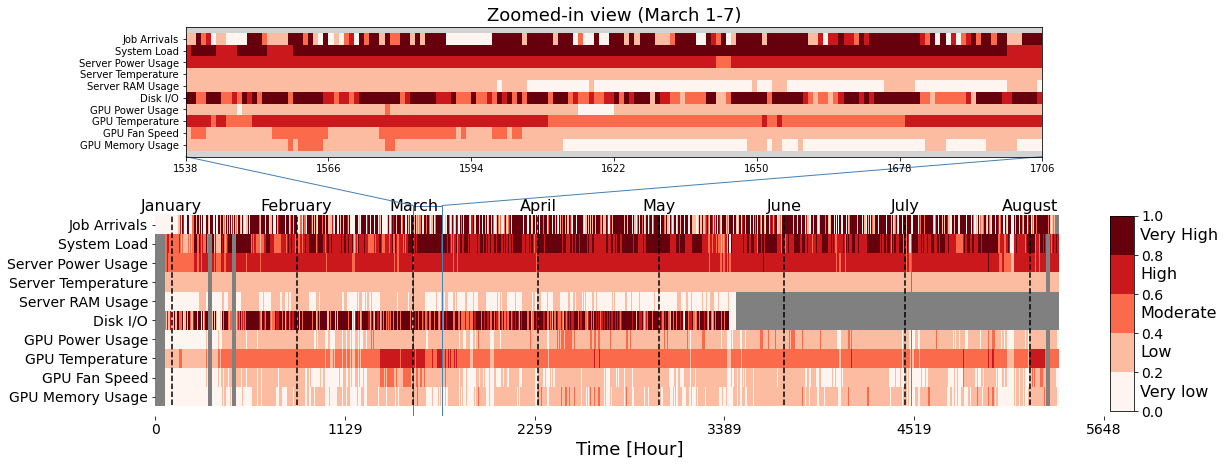

In [69]:
cmap = plt.cm.get_cmap('Reds').copy()
cmap.set_bad(color='grey')
# cNorm = plt.cm.colors.Normalize(vmin=0, vmax=1)  # Use this one if you want a linear gradient
cNorm = mpl.colors.BoundaryNorm(np.linspace(0, 1, 6), cmap.N)  # Use this one if you want a discrete gradient
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=cmap)


fig, ax = plt.subplots(figsize=(17, 4))
ax.invert_yaxis()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlabel("Time [Hour]", fontsize=18)

#https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

left = 0
for index, row in df.iterrows():  # Iterate over all the rows
    width = index - (start+left)  # Get how wide this piece should be, based on the previous value (timestamp) to account for big gaps
    lefts = [left] * len(df.columns)  # For all values, set the offset
    # VERY IMPORTANT TO USE MASK_INVALID!! MATPLOTLIB DOES NOT HANDLE NANS - https://stackoverflow.com/questions/52496817/matplotlib-colormaps-set-bad-doesnt-have-an-impact-with-collections
    colors = scalarMap.to_rgba(np.ma.masked_invalid(row))  # Compute the colors for this particular slice
    ax.barh(df.columns, width=width, left=lefts, height=1.0, linewidth=0, label=df.columns, color=colors, rasterized=True)
    left += width  # update left

def get_converted_xticks(ax):
    """
    :param ax:
    :return list of day and month strings
    """
    # return [pd.to_datetime(start + tick, unit='s').date().strftime("%d\n%b") for tick in ax.get_xticks()]
    return [int((tick) / 3600) for tick in ax.get_xticks()]  # Get the hour number

ax.set_xticks(np.linspace(0, ax.get_xlim()[1], num=6, dtype=int))  # Make sure we include 0 and the last value in the plot, so set the xticks ourselves
ax.set_xticklabels(get_converted_xticks(ax))

# Draw a line at the start of each month + annotate the date
first_line = pd.to_datetime(df.index[0], unit='s').date()
cur_year = first_line.year
cur_month = first_line.month
cur_month += 1
if cur_month == 13:
    cur_month = 1
    cur_year += 1
start_next_month = time.mktime(datetime(cur_year, cur_month, 1).timetuple())
while start_next_month <= df.index[-1]:
    ax.axvline(start_next_month - start, ymin=0.05, ymax=0.95, color='black', linestyle='dashed')  # seems we have some margin due to hbars?
    ax.text(x=start_next_month - start, y=-0.7, s=datetime(cur_year, cur_month, 1).strftime("%B"), fontsize=16, ha="center")
    cur_month += 1
    if cur_month == 13:
        cur_month = 1
        cur_year += 1
    start_next_month = time.mktime(datetime(cur_year, cur_month, 1).timetuple())

# Based on https://stackoverflow.com/a/39938019 and https://stackoverflow.com/a/39938019
pos = ax.get_position()
pad = 0.005
width = 0.02
ax2 = fig.add_axes([pos.xmax + pad, pos.ymin + 0.04, width, 0.9 * (pos.ymax - pos.ymin)])  # x, y, width, height
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
label_pad_pos = [.1, .3, .5, .7, .9]
label_pad_text = ["Very low", "Low", "Moderate", "High", "Very High"]
for y, text in zip(label_pad_pos, label_pad_text):
    ax2.text(1.25, y, text, ha='left', va='center', fontsize=16)

# Add a zoomed-in part
ax3 = fig.add_axes([0.15, 1.05, .7, .45], facecolor='lightgrey')
start_zoom = time.mktime(datetime(cur_year, 3, 1).timetuple())  # March 1
end_zoom = time.mktime(datetime(cur_year, 3, 8).timetuple())  # March 7 (one week)
zoom_df = df[(df.index >= start_zoom) & (df.index <= end_zoom)]
left = 0
for index, row in zoom_df.iterrows():  # Iterate over all the rows
    width = index - (start+left)  # Get how wide this piece should be, based on the previous value (timestamp) to account for big gaps
    lefts = [left] * len(zoom_df.columns)  # For all values, set the offset
    # VERY IMPORTANT TO USE MASK_INVALID!! MATPLOTLIB DOES NOT HANDLE NANS - https://stackoverflow.com/questions/52496817/matplotlib-colormaps-set-bad-doesnt-have-an-impact-with-collections
    colors = scalarMap.to_rgba(np.ma.masked_invalid(row))  # Compute the colors for this particular slice
    ax3.barh(zoom_df.columns, width=width, left=lefts, height=1.0, linewidth=0, label=zoom_df.columns, color=colors, rasterized=True)
    left += width  # update left

ax3.set_title('Zoomed-in view (March 1-7)', fontsize=18)
zoom_range = np.linspace((start_zoom - start), (start_zoom - start) + (end_zoom - start_zoom), num=7, dtype=int)
ax3.set_xlim(zoom_range[0], zoom_range[-1])
ax3.xaxis.set_major_locator(FixedLocator(zoom_range))
ax3.set_xticklabels(get_converted_xticks(ax3))
ax3.invert_yaxis()

mark_inset(ax, ax3, loc1=3, loc2=4, fc="none", ec="steelblue")

# == end zoomed-in code ==

fig.colorbar(scalarMap, cax=ax2)
fig.subplots_adjust(bottom=0.15)

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"generic_bottleneck_surf_{date_time}.pdf", bbox_inches = "tight")
fig.savefig(f"generic_bottleneck_surf_{date_time}.png", bbox_inches = "tight")

In [ ]:
df.isnull().sum(axis=0)

In [ ]:
bl = df['Server RAM Usage'].copy()
bl.index = pd.to_datetime(bl.index, utc=True, unit="s")
bl.resample('1H', label='right').max().isnull().sum()

In [18]:
tresholds = [0, .2, .4, .6, .8, 1]
series_to_use = [
    (job_arrival_df, "Job Arrivals"),
    (load1_df, "System Load"),
    (cluster_power_df, "Server Power Usage"),
    (rack_temp, "Server Temperature"),
    (memory_df, "Server RAM Usage"),
    (disk_io_df, "Disk I/O"),
    (gpu_power_df, "GPU Power Usage"),
    (gpu_temp, "GPU Temperature"),
    (gpu_fanspeed_df, "GPU Fan Speed"),
    (gpu_memory_df, "GPU Memory Usage"),
]

for series, name in series_to_use:
    print(name)
    num_elemnts = len(series)
    
    for i in range(1, len(tresholds)):
        num_elements_in_range = len(series[(series >= tresholds[i-1]) & (series < tresholds[i])])
        if num_elements_in_range > 0:
            amount = round(100 * (num_elements_in_range / num_elemnts), 1)
        else:
            amount = 0
        print(f"[{tresholds[i-1]}-{tresholds[i]}]: {amount}%")
    print("")

Job Arrivals
[0-0.2]: 96.3%
[0.2-0.4]: 1.9%
[0.4-0.6]: 0.4%
[0.6-0.8]: 0.2%
[0.8-1]: 0.1%

System Load
[0-0.2]: 0.9%
[0.2-0.4]: 2.8%
[0.4-0.6]: 18.2%
[0.6-0.8]: 44.6%
[0.8-1]: 20.2%

Server Power Usage
[0-0.2]: 0.0%
[0.2-0.4]: 0.5%
[0.4-0.6]: 12.9%
[0.6-0.8]: 86.4%
[0.8-1]: 0.1%

Server Temperature
[0-0.2]: 0%
[0.2-0.4]: 100.0%
[0.4-0.6]: 0%
[0.6-0.8]: 0%
[0.8-1]: 0%

Server RAM Usage
[0-0.2]: 66.7%
[0.2-0.4]: 33.3%
[0.4-0.6]: 0.0%
[0.6-0.8]: 0%
[0.8-1]: 0%

Disk I/O
[0-0.2]: 81.5%
[0.2-0.4]: 9.9%
[0.4-0.6]: 3.1%
[0.6-0.8]: 1.3%
[0.8-1]: 0.8%

GPU Power Usage
[0-0.2]: 34.6%
[0.2-0.4]: 64.4%
[0.4-0.6]: 1.0%
[0.6-0.8]: 0%
[0.8-1]: 0%

GPU Temperature
[0-0.2]: 0%
[0.2-0.4]: 12.5%
[0.4-0.6]: 80.7%
[0.6-0.8]: 6.9%
[0.8-1]: 0%

GPU Fan Speed
[0-0.2]: 41.2%
[0.2-0.4]: 56.5%
[0.4-0.6]: 2.3%
[0.6-0.8]: 0%
[0.8-1]: 0%

GPU Memory Usage
[0-0.2]: 40.4%
[0.2-0.4]: 58.5%
[0.4-0.6]: 1.1%
[0.6-0.8]: 0%
[0.8-1]: 0%

